In [7]:
#importing stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la

* center_sternum.txt: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively.

All .txt files give 16 columns index, in particular:
* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse
system.

### Assignments

Data preparation:

1.1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

1.2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.

1.3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.

Time and frequency analysis:

2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical
descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.

2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step.

Filter:

Implement your own filter, trying to extrapolate respiratory rate signal. Hint:

(a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.

(b) Choose the appropriate Lowpass/Bandpass/Highpass filter.

(c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal). (d) Find another method by yourselves.

Motivate your choice.

Metrics:

4.1. Respiratory Rate Per Minute(RPM): extrapolate RPM, make an histogram of the result. Does it follow a partiular distribution?

4.2. Respiratory Rate Variability(RRV): extrapolate RRV, explain why this parameter is important, and plot the results.

(OPTIONAL) Algorithm: Elaborate a simple algorithm to extrapolate respiratory rate even when filter failed (e.g. look at particular threshold...).

In [8]:
# what are we doing? we are trying to get the heart rate (HR) and resipiratory rate (RR)
# how are we going to do this?
# using two techniques, SCG and BCG, that need
# info about the mechanical properties of the human body such as acceleration, angular velocity

# first things first, we load the center_sternum dataset and add a time column as index
sampling_rate = 200 # calibration tells us the sampling rate
df=pd.read_csv("center_sternum.txt",sep=None,engine='python')
df['time_s'] = np.arange(0,df.shape[0])/sampling_rate # let's construct the time axis, with each sampling separated by a 100th of a second (because sampling rate is 100 Hz)
df=df.set_index('time_s')
df

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
time_s,,,,,,,,,,,,,,,,
0.000,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
0.005,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
0.010,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
0.015,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
0.020,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82.505,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
82.510,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
82.515,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502


<AxesSubplot:title={'center':'Second Time Window'}, xlabel='time_s'>

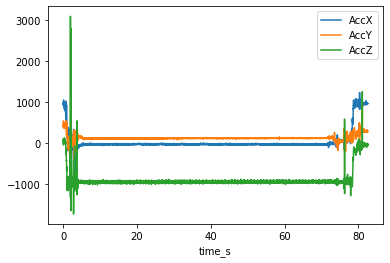

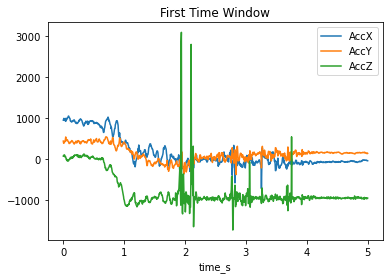

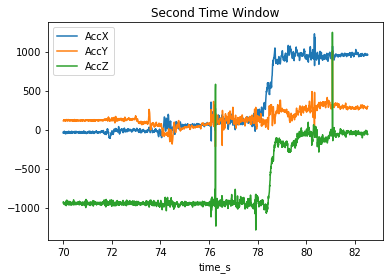

In [11]:
# now let's look at the acceleration vector by plotting its three components
df.plot(y=['AccX','AccY','AccZ'])
df.loc[0:5].plot(y=['AccX','AccY','AccZ'],title='First Time Window')
df.loc[70:].plot(y=['AccX','AccY','AccZ'],title='Second Time Window')




In [ ]:
# lets focus on the first time window

c=df.loc[0:20][['AccX','AccY','AccZ']].cov()
l,V=la.eig(c) #V[:,i] is the normalized eigenvector corresponding to the l[i] eigenvalue 
l_r=np.real_if_close(l)
print("Contributions to variance along the three eigenvectors' direction:")
with np.printoptions(precision=3, suppress=True):
    print(l_r/c.values.trace()) # there is little variance along the third eigenvector, just about 0.02%
# that means that if we transform the data and drop the third component we should be good
# df_acc_transf = (V.T @ df.loc[0:20][['AccX','AccY','AccZ']].T).T

pd.plotting.scatter_matrix(df.loc[0:20][['AccX','AccY','AccZ']])
pd.plotting.scatter_matrix(df_acc_transf)

<AxesSubplot:xlabel='time_s'>

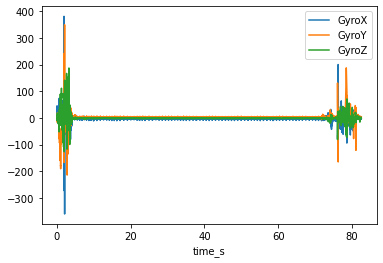

In [12]:
df.plot(y=['GyroX','GyroY','GyroZ'])

<AxesSubplot:xlabel='time_s'>

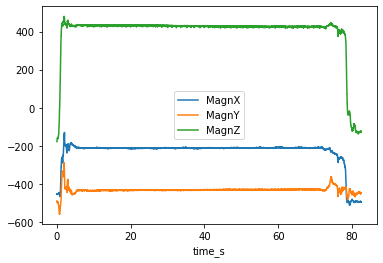

In [13]:
df.plot(y=['MagnX','MagnY','MagnZ'])